# Smart Home energy consuption prediction

We have taken a smart home dataset to predict the energy consumption of the house using LTSM model. Based on previous comparions with vanilla RNN and GRU models, the LTSM shines really well with the R^2 value after the modelis trained and tested as well as easier to deploy.

## Selected Dataset/Environment
The selected Dataset is: Smart Home Dataset with weather Information https://www.kaggle.com/datasets/taranvee/smart-home-dataset-with-weather-information. This IOT dataset contains
the readings with a time span of 1 minute of house appliances in kW from a smart meter and weather
conditions.

## Problem Statement
Given certain weather and market conditions, the cost of energy increases and decreases. In a home,
there are certain periods in a day when operating certain energy-consuming appliances are preferable.
Such as running the dishwasher, etc. When information regarding the surrounding weather is given, how
can we determine the best time to operate and run these appliances, so we consume the least amount
of energy? With any machine learning techniques could we extract some more meaningful information
about the residents and their behavior from this dataset? Could we use that extracted data to discover
new means to save energy?

## Goals and Objective
The goal of the project is to optimize the energy consumption of a house using a Supervised Machine Learning model. The objective is to use a Regression Machine Learning Model to help determine the optimal times to use household appliances and reduce the net energy consumption of the household.

## Solution
The proposed solution is mentioned in the steps below:
1.	Collect the raw data containing the household appliance energy consumption data in one-minute intervals.
2.	Train the LTSM Neural Network model using the raw data (raw data is split into train and test datasets).
3.	Test the model for performance metrics and evaluate if the performance is acceptable.
4.	Use the model on the data to find insights on optimal times in a given day to run appliances to increase the energy efficiency of the house.
5.	Report the findings and results.

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Import

In [2]:
data = pd.read_csv("input_data/Home_IOT_data.csv",low_memory=False)
data = data[:-1] #delete last row  (NaNs)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503910 entries, 0 to 503909
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503910 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]            503910 non-null  float64
 15  Well [kW]        

In [3]:
data.head(2)

time  use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  \
0  1451624400  0.932833  0.003483            0.932833         0.000033   
1  1451624401  0.934333  0.003467            0.934333         0.000000   

   Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  \
0        0.020700        0.061917          0.442633      0.12415   
1        0.020717        0.063817          0.444067      0.12400   

   Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  Kitchen 14 [kW]  \
0          0.006983          0.013083         0.000417          0.00015   
1          0.006983          0.013117         0.000417          0.00015   

   Kitchen 38 [kW]  Barn [kW]  Well [kW]  Microwave [kW]  Living room [kW]  \
0              0.0    0.03135   0.001017        0.004067          0.001517   
1              0.0    0.03150   0.001017        0.004067          0.001650   

   Solar [kW]  temperature         icon  humidity  visibility summary  \
0    0.003483        36.14  clear-night      0.62        10.0   Clear   
1    0.003467        36.14  clear-night      0.62        10.0   Clear   

   apparentTemperature  pressure  windSpeed  cloudCover  windBearing  \
0                29.26   1016.91       9.18  cloudCover        282.0   
1                29.26   1016.91       9.18  cloudCover        282.0   

   precipIntensity  dewPoint  precipProbability  
0              0.0      24.4                0.0  
1              0.0      24.4                0.0

# Cleaning the dataset

In [4]:
#Convert Unix timestamp to datetime, use sample frequency of minutes and make it dataframe index
data['time'] = pd.to_datetime(data['time'], unit='s')
data['time'] = pd.DatetimeIndex(pd.date_range('2016-01-01 05:00', periods=len(data),  freq='min'))
data = data.set_index('time')
data.head(2)

use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  \
time                                                                           
2016-01-01 05:00:00  0.932833  0.003483            0.932833         0.000033   
2016-01-01 05:01:00  0.934333  0.003467            0.934333         0.000000   

                     Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  \
time                                                                    
2016-01-01 05:00:00        0.020700        0.061917          0.442633   
2016-01-01 05:01:00        0.020717        0.063817          0.444067   

                     Fridge [kW]  Wine cellar [kW]  Garage door [kW]  \
time                                                                   
2016-01-01 05:00:00      0.12415          0.006983          0.013083   
2016-01-01 05:01:00      0.12400          0.006983          0.013117   

                     Kitchen 12 [kW]  Kitchen 14 [kW]  Kitchen 38 [kW]  \
time                                                                     
2016-01-01 05:00:00         0.000417          0.00015              0.0   
2016-01-01 05:01:00         0.000417          0.00015              0.0   

                     Barn [kW]  Well [kW]  Microwave [kW]  Living room [kW]  \
time                                                                          
2016-01-01 05:00:00    0.03135   0.001017        0.004067          0.001517   
2016-01-01 05:01:00    0.03150   0.001017        0.004067          0.001650   

                     Solar [kW]  temperature         icon  humidity  \
time                                                                  
2016-01-01 05:00:00    0.003483        36.14  clear-night      0.62   
2016-01-01 05:01:00    0.003467        36.14  clear-night      0.62   

                     visibility summary  apparentTemperature  pressure  \
time                                                                     
2016-01-01 05:00:00        10.0   Clear                29.26   1016.91   
2016-01-01 05:01:00        10.0   Clear                29.26   1016.91   

                     windSpeed  cloudCover  windBearing  precipIntensity  \
time                                                                       
2016-01-01 05:00:00       9.18  cloudCover        282.0              0.0   
2016-01-01 05:01:00       9.18  cloudCover        282.0              0.0   

                     dewPoint  precipProbability  
time                                              
2016-01-01 05:00:00      24.4                0.0  
2016-01-01 05:01:00      24.4                0.0

In [5]:
data['summary'].unique()

array(['Clear', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy', 'Drizzle',
       'Light Rain', 'Rain', 'Light Snow', 'Flurries', 'Breezy', 'Snow',
       'Rain and Breezy', 'Foggy', 'Breezy and Mostly Cloudy',
       'Breezy and Partly Cloudy', 'Flurries and Breezy', 'Dry',
       'Heavy Snow'], dtype=object)

In [6]:
#Delete '[kW]' in columns name, sum similar consumtions and delete 'summary' column
data.columns = [i.replace(' [kW]', '') for i in data.columns]
data['Furnace'] = data[['Furnace 1','Furnace 2']].sum(axis=1)
data['Kitchen'] = data[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1) #We could also use the mean 
data.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','summary'], axis=1, inplace=True)

#Replace invalid values in column 'cloudCover' with backfill method
data['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
data['cloudCover'] = data['cloudCover'].astype('float')

#Reorder columns for better visualization
data = data[['use', 'gen', 'House overall', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar', 'Garage door', 'Barn',
             'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen', 'Solar', 'temperature', 'humidity', 'visibility', 
             'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 
             'dewPoint', 'precipProbability']]
data.head(2)

use       gen  House overall  Dishwasher  \
time                                                                 
2016-01-01 05:00:00  0.932833  0.003483       0.932833    0.000033   
2016-01-01 05:01:00  0.934333  0.003467       0.934333    0.000000   

                     Home office   Fridge  Wine cellar  Garage door     Barn  \
time                                                                           
2016-01-01 05:00:00     0.442633  0.12415     0.006983     0.013083  0.03135   
2016-01-01 05:01:00     0.444067  0.12400     0.006983     0.013117  0.03150   

                         Well  Microwave  Living room   Furnace   Kitchen  \
time                                                                        
2016-01-01 05:00:00  0.001017   0.004067     0.001517  0.082617  0.000567   
2016-01-01 05:01:00  0.001017   0.004067     0.001650  0.084533  0.000567   

                        Solar  temperature  humidity  visibility  \
time                                                               
2016-01-01 05:00:00  0.003483        36.14      0.62        10.0   
2016-01-01 05:01:00  0.003467        36.14      0.62        10.0   

                     apparentTemperature  pressure  windSpeed  cloudCover  \
time                                                                        
2016-01-01 05:00:00                29.26   1016.91       9.18        0.75   
2016-01-01 05:01:00                29.26   1016.91       9.18        0.75   

                     windBearing  precipIntensity  dewPoint  precipProbability  
time                                                                            
2016-01-01 05:00:00        282.0              0.0      24.4                0.0  
2016-01-01 05:01:00        282.0              0.0      24.4                0.0

## Energy correlations

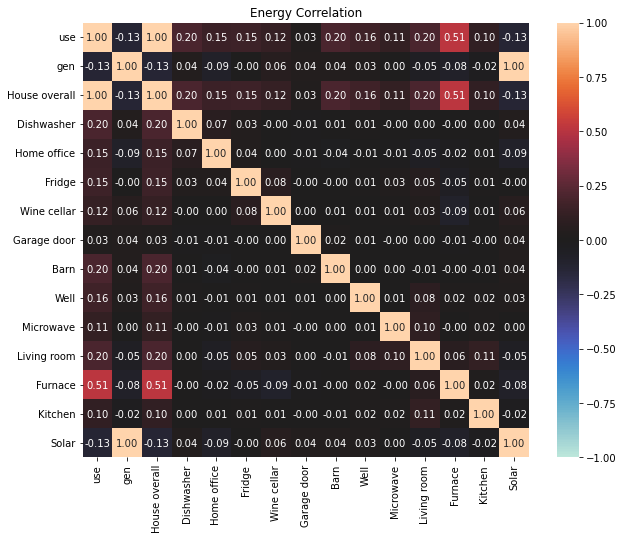

In [7]:
#Checking Correlations (Only Energy features) to understand which appliance/room consumes the most energy
fig = plt.subplots(figsize=(10, 8))
sns.heatmap(data[data.columns[0:15].tolist()].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Energy Correlation', fontsize=12);

In [8]:
#Some columns look so much correlated that they might be the same data
print(data['gen'].equals(data['Solar']))
print(data['use'].equals(data['House overall']))
#'True' if all elements in the columns coincide
# If both ar etrue, then we should drop the columns

True
True


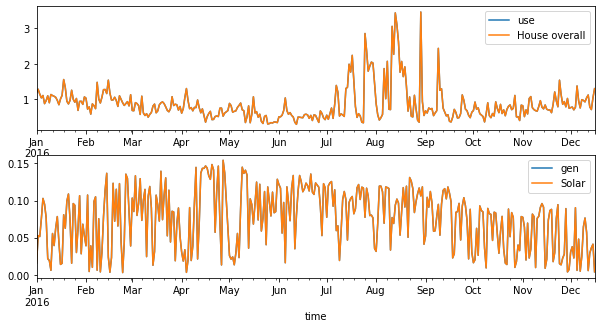

In [9]:
#They are indeed the same data (overlaping perfectly)
fig, axes = plt.subplots(2,1, figsize=(10,5))
data[['use','House overall']].resample('D').mean().plot(ax=axes[0])
data[['gen','Solar']].resample('D').mean().plot(ax=axes[1]);

In [10]:
#Drop the duplicate ones since 'use' == 'House overall' and 'gen' == 'Solar'
data.drop(['use', 'gen'], axis=1, inplace=True)

## Weather correlations to understand the relationship between weather features

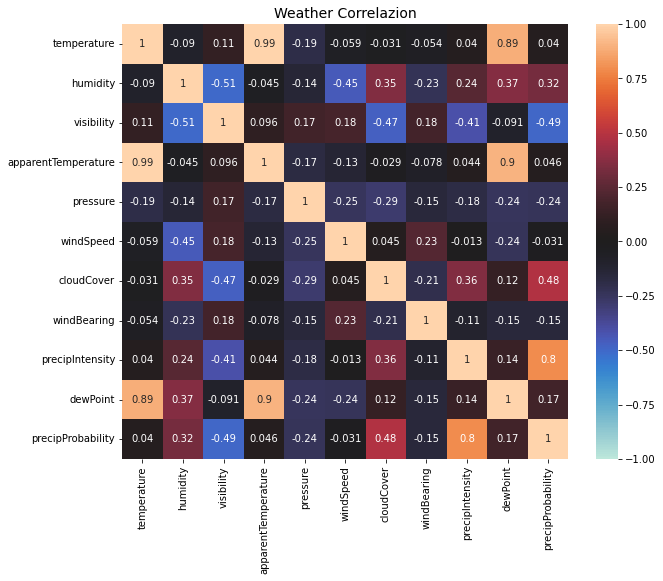

In [11]:
#Checking Correlations (only weather features)
fig = plt.subplots(figsize=(10, 8)) 
sns.heatmap(data[data.columns[13:].tolist()].corr(), annot=True, vmin=-1.0, vmax=1.0, center=0)
plt.title('Weather Correlazion', fontsize=14);

<AxesSubplot:xlabel='time'>

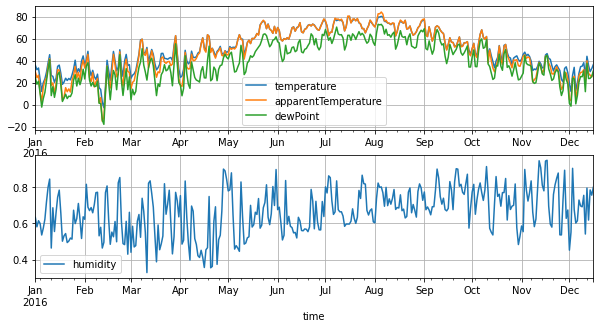

In [12]:
#Let's check a few correlations about the weather data
fig, axes = plt.subplots(2,1, figsize=(10,5))
data[['temperature','apparentTemperature', 'dewPoint']].resample('D').mean().plot(ax=axes[0], grid=True)
data[['humidity']].resample('D').mean().plot(ax=axes[1], grid=True)

### Temperature difference

In [13]:
# Check correlations between diff(apparentTemperature, temperature) and other weather columns 
data['Tdiff'] = (data['apparentTemperature']-data['temperature'])
clima = data.columns[13:-1].tolist()
lista_corr = []
for i in clima:
  cor = data[i].corr(data['Tdiff'])
  lista_corr.append(cor)
data_corr = pd.DataFrame(list(zip(clima, lista_corr)), columns=['weather','Tdiff_corr']).set_index('weather')
data_corr

Tdiff_corr
weather                        
temperature            0.732693
humidity               0.188441
visibility            -0.018984
apparentTemperature    0.807018
pressure              -0.029497
windSpeed             -0.465971
cloudCover            -0.013172
windBearing           -0.180131
precipIntensity        0.055953
dewPoint               0.753312
precipProbability      0.068525

<AxesSubplot:xlabel='time'>

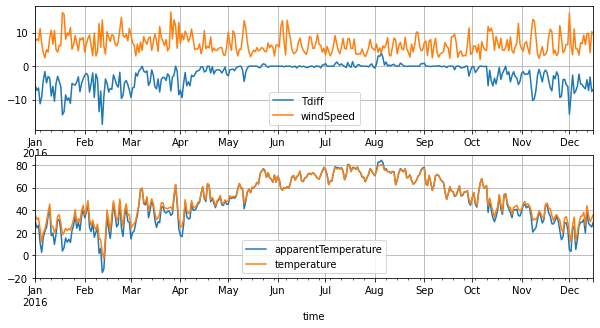

In [14]:
fig, axes = plt.subplots(2,1, figsize=(10,5))
data[['Tdiff','windSpeed']].resample('D').mean().plot(ax=axes[0], grid=True)
data[['apparentTemperature', 'temperature']].resample('D').mean().plot(ax=axes[1], grid=True)

In [15]:
data.drop('Tdiff', axis=1, inplace=True)

# Visualizations

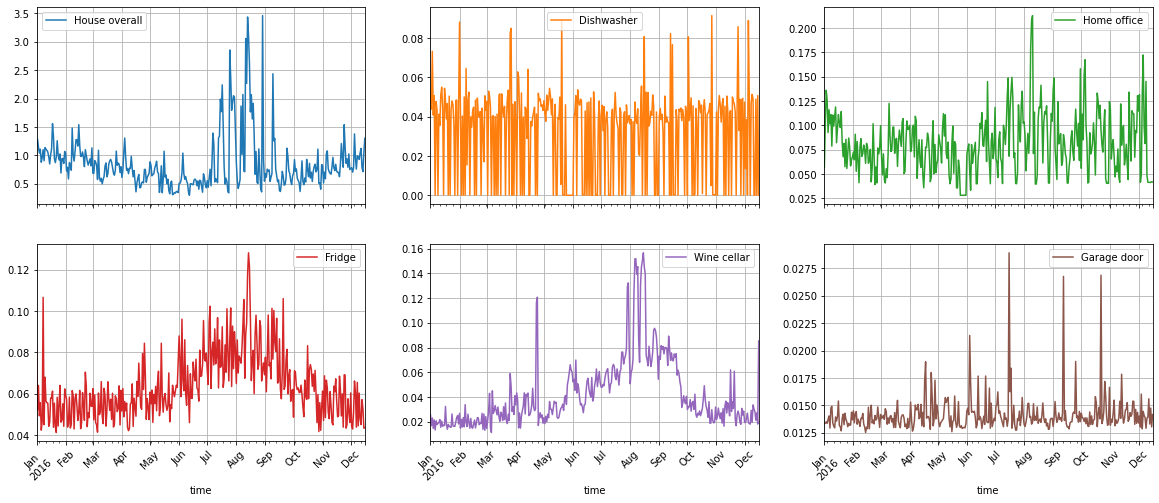

In [16]:
#First 6 Energy columns (resample by day (rule=D or 1440Min))
data[data.columns[0:6].tolist()].resample("D").mean().plot(subplots=True, layout=(-1, 3), figsize=(20, 8),
                                                                grid=True, rot=45);

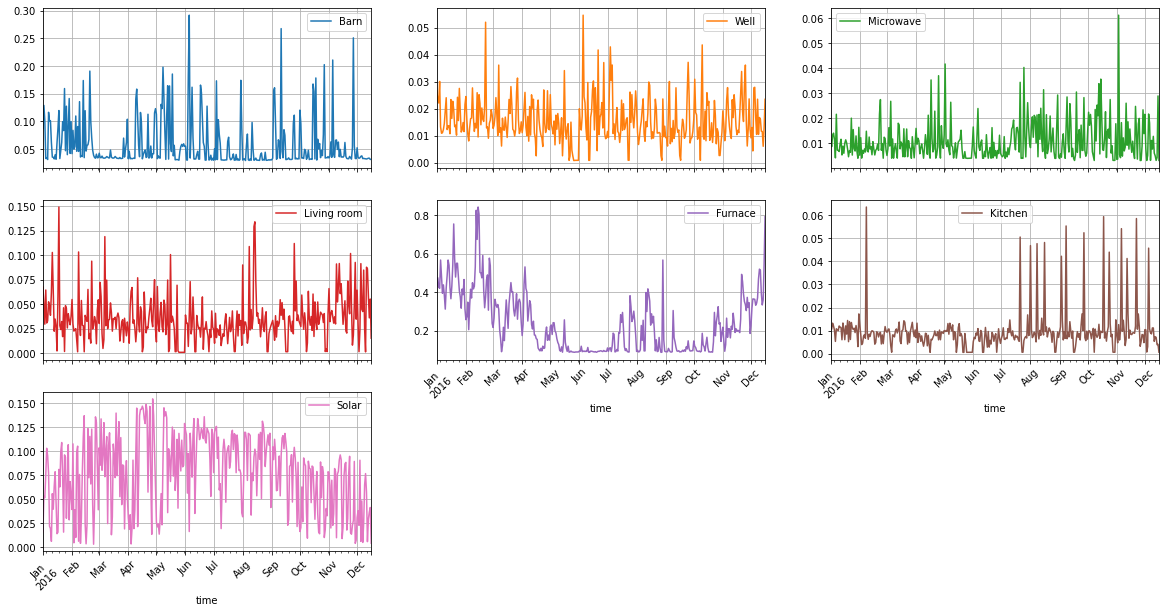

In [17]:
# Rest of Energy columns
data[data.columns[6:13].tolist()].resample("D").mean().plot(subplots=True, layout=(-1, 3), figsize=(20, 10),
                                                                grid=True, rot=45, xlabel=None);

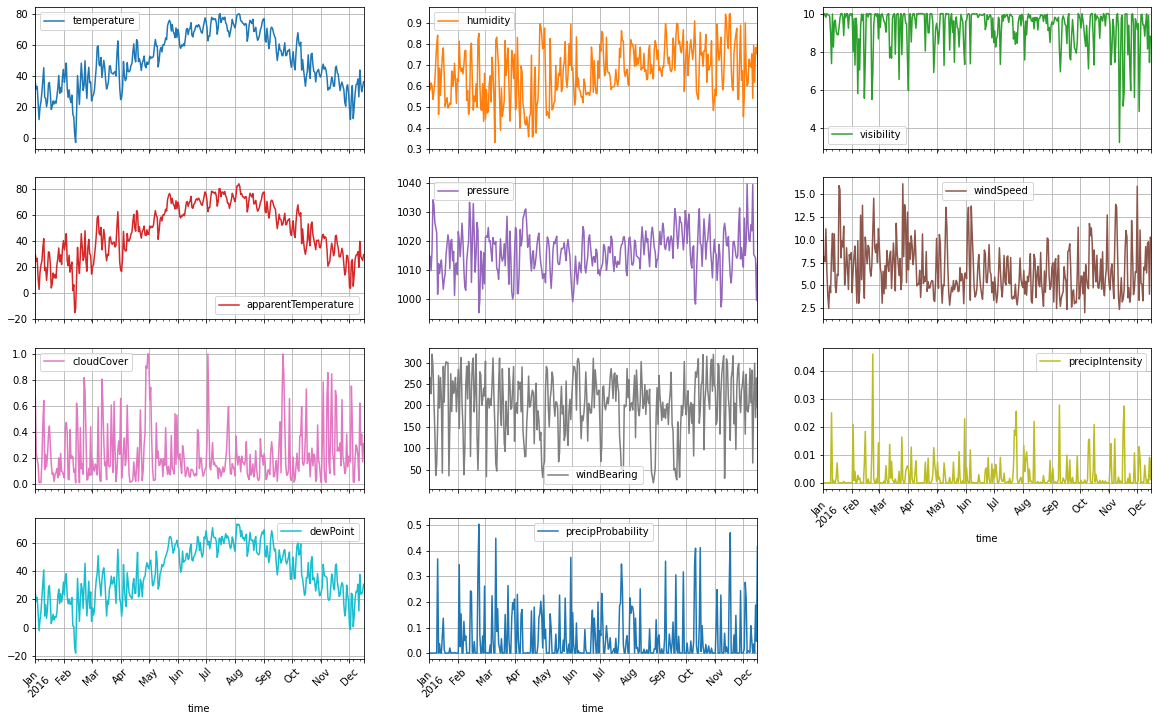

In [18]:
#Visualize wheather data
data[data.columns[13:].tolist()].resample("D").mean().plot(subplots=True, layout=(-1, 3), figsize=(20, 12),
                                                                grid=True, rot=45, xlabel=None);

# Groupings

In [19]:
#Define new columns from datetime
data['month'] = data.index.month
data['day'] = data.index.day
data['weekday'] = data.index.day_name()
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data.head(2)

House overall  Dishwasher  Home office   Fridge  \
time                                                                   
2016-01-01 05:00:00       0.932833    0.000033     0.442633  0.12415   
2016-01-01 05:01:00       0.934333    0.000000     0.444067  0.12400   

                     Wine cellar  Garage door     Barn      Well  Microwave  \
time                                                                          
2016-01-01 05:00:00     0.006983     0.013083  0.03135  0.001017   0.004067   
2016-01-01 05:01:00     0.006983     0.013117  0.03150  0.001017   0.004067   

                     Living room   Furnace   Kitchen     Solar  temperature  \
time                                                                          
2016-01-01 05:00:00     0.001517  0.082617  0.000567  0.003483        36.14   
2016-01-01 05:01:00     0.001650  0.084533  0.000567  0.003467        36.14   

                     humidity  visibility  apparentTemperature  pressure  \
time                                                                       
2016-01-01 05:00:00      0.62        10.0                29.26   1016.91   
2016-01-01 05:01:00      0.62        10.0                29.26   1016.91   

                     windSpeed  cloudCover  windBearing  precipIntensity  \
time                                                                       
2016-01-01 05:00:00       9.18        0.75        282.0              0.0   
2016-01-01 05:01:00       9.18        0.75        282.0              0.0   

                     dewPoint  precipProbability  month  day weekday  hour  \
time                                                                         
2016-01-01 05:00:00      24.4                0.0      1    1  Friday     5   
2016-01-01 05:01:00      24.4                0.0      1    1  Friday     5   

                     minute  
time                         
2016-01-01 05:00:00       0  
2016-01-01 05:01:00       1

## Month

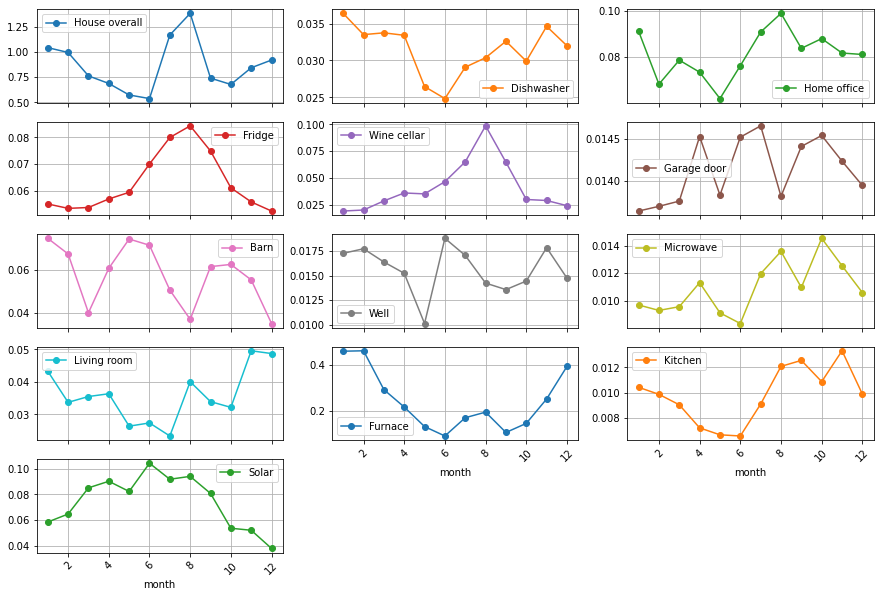

In [20]:
##Averge consuption per month
mean_month = data.groupby('month').agg({i:'mean' for i in data.columns[:-5].tolist()})
mean_month[mean_month.columns[0:13].tolist()].plot(subplots=True, layout=(-1, 3), figsize=(15, 10),
                                                       grid=True, rot=45, xlabel=None, marker='o');

### Weekday

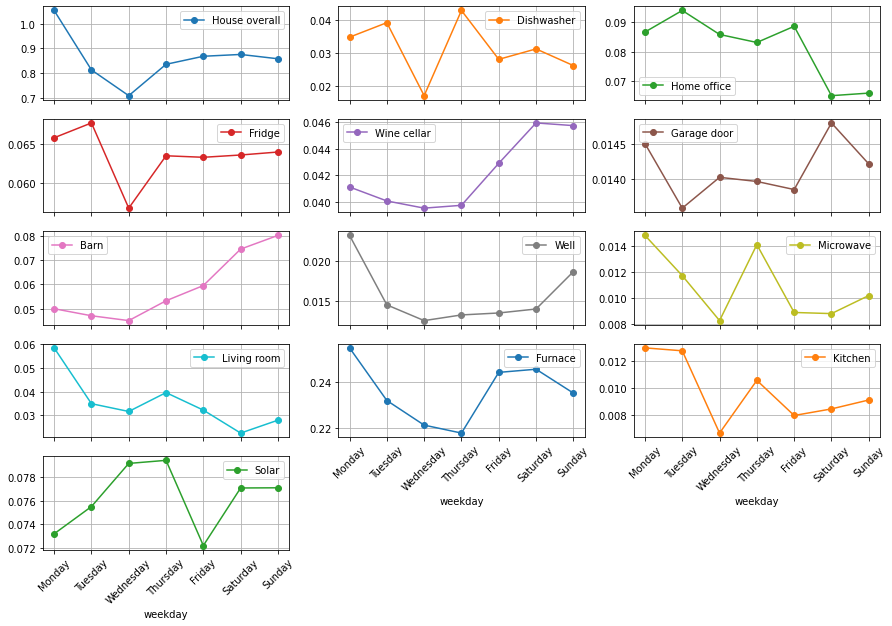

In [21]:
#Averge consuption per day of the week
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_weekday = data.groupby('weekday').agg({i:'mean' for i in data.columns[:-5].tolist()}).reindex(days)

mean_weekday[mean_weekday.columns[0:13].tolist()].plot(subplots=True, layout=(-1, 3), figsize=(15, 10),
                                                       grid=True, rot=45, xlabel=None, marker='o');

### Hour

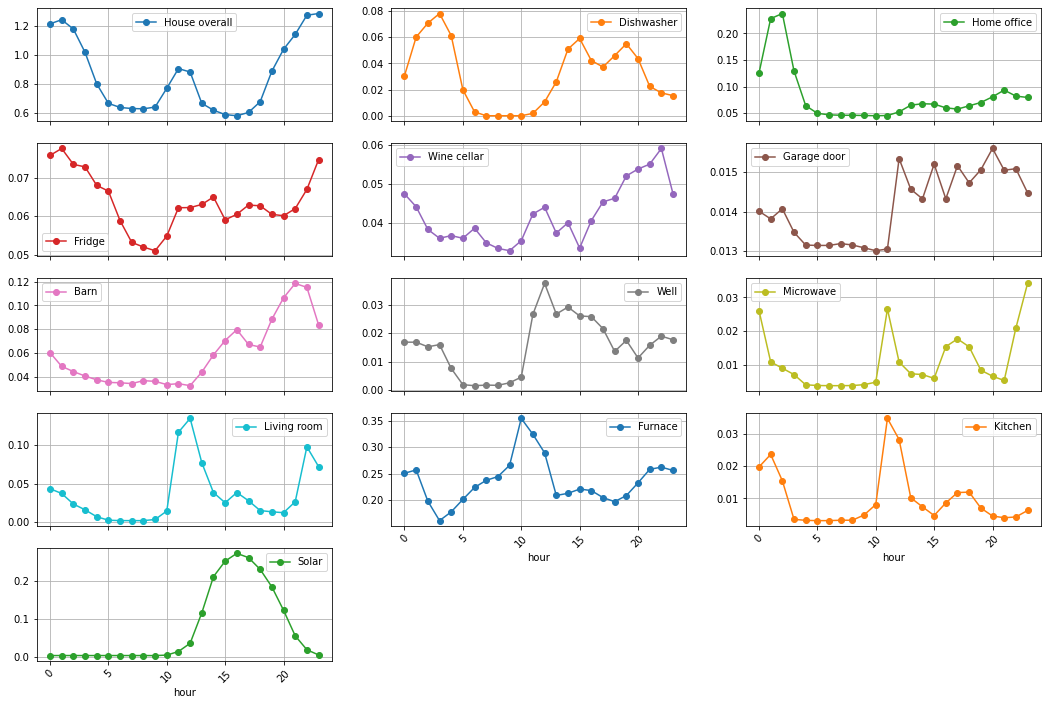

In [22]:
#Averge consuption per hour
mean_hour = data.groupby('hour').agg({i:'mean' for i in data.columns[:-5].tolist()})

mean_hour[mean_hour.columns[0:13].tolist()].plot(subplots=True, layout=(-1, 3), figsize=(18, 12),
                                                       grid=True, rot=45, xlabel=None, marker='o');

# Energy-Weather Correlations

In [23]:
consumtions = data.columns[0:13].tolist()
weather = data.columns[13:-5].tolist()
lists = [consumtions,]
for j in weather:
    correlations = []
    for i in consumtions:
        cor = data[i].corr(data[j])
        correlations.append(cor)
    lists.append(correlations)

names=['consumtions']
for i in weather:
    names.append(i+'_corr')
dataframe_corr = pd.DataFrame(np.column_stack(lists), columns=names).set_index('consumtions')

for i in dataframe_corr.columns[:].tolist():
    dataframe_corr[i] = dataframe_corr[i].apply(float)

In [24]:
#Highlight correlations between energy and weather (red for corr > 0.1, orange for corr < -0.1)
dataframe_corr.style.applymap(lambda x: "background-color: red" if x > 0.1 else "background-color: orange" if x < -0.1 else "background-color: white")

# More feature exploration

In [25]:
#Check whether House overall corresponds to the sum of other comsumpitons (it seems not)
data['Sum_usage'] = data[list(data.columns[1:12])].sum(axis=1)
data['Usage_diff'] = data['House overall'] - data['Sum_usage']
data.head(2)

House overall  Dishwasher  Home office   Fridge  \
time                                                                   
2016-01-01 05:00:00       0.932833    0.000033     0.442633  0.12415   
2016-01-01 05:01:00       0.934333    0.000000     0.444067  0.12400   

                     Wine cellar  Garage door     Barn      Well  Microwave  \
time                                                                          
2016-01-01 05:00:00     0.006983     0.013083  0.03135  0.001017   0.004067   
2016-01-01 05:01:00     0.006983     0.013117  0.03150  0.001017   0.004067   

                     Living room   Furnace   Kitchen     Solar  temperature  \
time                                                                          
2016-01-01 05:00:00     0.001517  0.082617  0.000567  0.003483        36.14   
2016-01-01 05:01:00     0.001650  0.084533  0.000567  0.003467        36.14   

                     humidity  visibility  apparentTemperature  pressure  \
time                                                                       
2016-01-01 05:00:00      0.62        10.0                29.26   1016.91   
2016-01-01 05:01:00      0.62        10.0                29.26   1016.91   

                     windSpeed  cloudCover  windBearing  precipIntensity  \
time                                                                       
2016-01-01 05:00:00       9.18        0.75        282.0              0.0   
2016-01-01 05:01:00       9.18        0.75        282.0              0.0   

                     dewPoint  precipProbability  month  day weekday  hour  \
time                                                                         
2016-01-01 05:00:00      24.4                0.0      1    1  Friday     5   
2016-01-01 05:01:00      24.4                0.0      1    1  Friday     5   

                     minute  Sum_usage  Usage_diff  
time                                                
2016-01-01 05:00:00       0   0.708017    0.224817  
2016-01-01 05:01:00       1   0.711500    0.222833

<AxesSubplot:xlabel='time'>

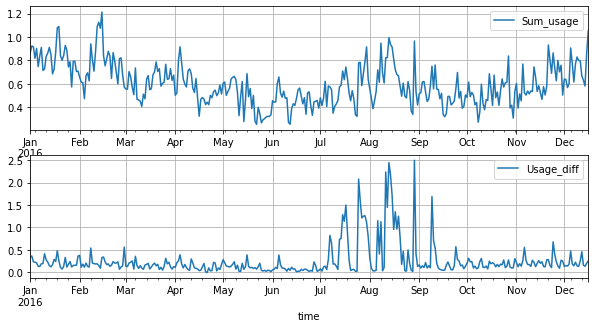

In [26]:
fig, axes = plt.subplots(2,1, figsize=(10,5))
data['Sum_usage'].resample('D').mean().plot(ax=axes[0], grid=True, legend=True)
data['Usage_diff'].resample('D').mean().plot(ax=axes[1], grid=True, legend=True)

# Anomaly detection
We need the confidence interval. Here some explanations and clarifications. https://machinelearningmastery.com/prediction-intervals-for-machine-learning/

## Moving Average

In [27]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average with window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "g--" , label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "g--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=5)
        
    plt.plot(series[window:], 'blue', label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True), plt.margins(x=0);


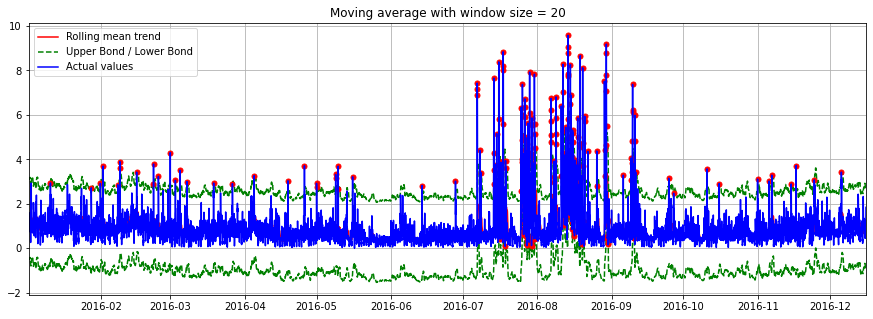

In [28]:
data_anom = data.resample('H').mean()
cols=['House overall']
plotMovingAverage(data_anom[cols], window=20, plot_intervals=True, plot_anomalies=True)

In [29]:
len(data_anom)

8399

In [30]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data_anom['House overall'], order=(2,1,1))
#model = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(5,0,1,12))
model_fit = model.fit()
print('Akaike information criterion: ', model_fit.aic)

Akaike information criterion:  12246.579900914976


### ARIMA v2 to explore the outliers in the data

In [31]:
predictions = model_fit.predict(dynamic=False)

confidence = model_fit.get_prediction().conf_int(alpha=0.01)
#Errors = np.abs(data_anom['use'] - predictions) 
Errors = np.sqrt(mean_squared_error(data_anom['House overall'], predictions)) 
Uncertainty = confidence['upper House overall'] - confidence['lower House overall']
Anomalies = data_anom['House overall'][(data_anom['House overall']> confidence['upper House overall'])|
                                  (data_anom['House overall'] < confidence['lower House overall'])]
#Anomalies = dati_anom['use'][Errors > Uncertainty]    

In [32]:
Anomalies

time
2016-01-06 23:00:00    2.156540
2016-01-10 23:00:00    2.937022
2016-01-28 00:00:00    2.716433
2016-01-31 19:00:00    2.914677
2016-02-01 22:00:00    3.695435
2016-02-08 01:00:00    2.854421
2016-02-08 22:00:00    3.897552
2016-02-15 22:00:00    3.422092
2016-02-22 22:00:00    2.903372
2016-02-22 23:00:00    3.787728
2016-02-25 00:00:00    3.231062
2016-02-29 23:00:00    4.302675
2016-03-01 00:00:00    1.044419
2016-03-03 02:00:00    3.060666
2016-03-05 00:00:00    3.509468
2016-03-05 01:00:00    1.516843
2016-03-07 21:00:00    2.427096
2016-03-13 21:00:00    2.055749
2016-03-18 23:00:00    2.552387
2016-03-21 22:00:00    2.486144
2016-03-26 19:00:00    1.928089
2016-03-26 21:00:00    2.904957
2016-04-03 22:00:00    2.354791
2016-04-04 22:00:00    3.262371
2016-04-19 01:00:00    3.032854
2016-04-19 02:00:00    1.072022
2016-04-25 22:00:00    3.707535
2016-04-25 23:00:00    1.475218
2016-04-26 00:00:00    2.425648
2016-04-30 23:00:00    2.915975
2016-05-08 22:00:00    3.318190
201

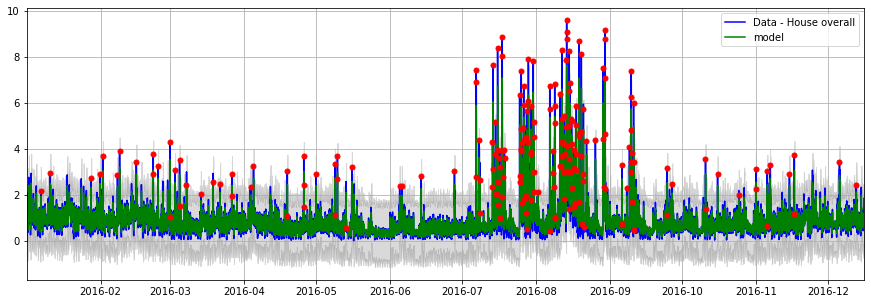

In [33]:
plt.figure(figsize=(15,5))
plt.plot(data_anom['House overall'], c='blue',label='Data - House overall')
plt.plot(predictions, c='green', label='model')
plt.fill_between(confidence.index[1:],confidence['lower House overall'][1:],
                 confidence['upper House overall'][1:], color='k', alpha=.15)
plt.plot(Anomalies, "ro", markersize=5)
plt.legend()
plt.grid(), plt.margins(x=0);
#print(model_fit.summary())

## LSTM

In [34]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Bidirectional

In [35]:
#Define dataframe - Consumption "House overall" and weather data to include in the forecasting
data_daily = data_anom[['House overall', 'temperature', 'Furnace', 'Living room', 'Barn', 'humidity',
                   'apparentTemperature', 'pressure', 'cloudCover','windBearing', 'precipIntensity',
                   'dewPoint', 'precipProbability']]

In [36]:
#Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
data_daily[data_daily.columns[1:]] = scaler.fit_transform(data_daily[data_daily.columns[1:]])
scaler_target = MinMaxScaler(feature_range=(0, 1))
data_daily[['House overall']] = scaler_target.fit_transform(data_daily[['House overall']])

In [37]:
#Build the arrays train e test, sequencing the trace like in the univariate case, but this time we also include 
#weather.

X, Y = [], []
n_past=1    #timesteps
n_future=1  #punti da prevedere
for i in range(n_past, len(data_daily)-n_future+1):
    X.append(data_daily.iloc[i-n_past:i, 0:data_daily.shape[1]])
    Y.append(data_daily.iloc[i+n_future-1:i+n_future, 0])

X, Y = np.array(X), np.array(Y)

print('X shape', X.shape)
print('Y shape', Y.shape)





size = int(len(data_daily)*0.7)
data_daily_train = data_daily[:size]
data_daily_test = data_daily[size:]
X_train, X_test = [], []
Y_train, Y_test = [], []
n_past=1
n_future=1
for i in range(n_past, len(data_daily_train)-n_future+1):
    X_train.append(data_daily_train.iloc[i-n_past:i, 0:data_daily.shape[1]])
    Y_train.append(data_daily_train.iloc[i+n_future-1:i+n_future, 0])
for i in range(n_past, len(data_daily_test)-n_future+1):
    X_test.append(data_daily_test.iloc[i-n_past:i, 0:data_daily_test.shape[1]])
    Y_test.append(data_daily_test.iloc[i+n_future-1:i+n_future, 0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('Y_train shape', Y_train.shape)
print('Y_test shape', Y_test.shape)

X shape (8398, 1, 13)
Y shape (8398, 1)
X_train shape (5878, 1, 13)
X_test shape (2519, 1, 13)
Y_train shape (5878, 1)
Y_test shape (2519, 1)


In [38]:
model = Sequential()
model.add(LSTM(10, activation='relu', return_sequences = False,  input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(50, activation='relu', return_sequences = True))
#model.add(LSTM(25, activation='relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                960       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 971
Trainable params: 971
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_fit = model.fit(X_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, Y_test))
Train_pred = model.predict(X_train, verbose=0)
Y_pred = model.predict(X_test, verbose=0)

model.save(f'output_data/model_data/LSTM_Model_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}')

Epoch 1/50
184/184 - 2s - loss: 0.0092 - val_loss: 0.0024 - 2s/epoch - 11ms/step
Epoch 2/50
184/184 - 0s - loss: 0.0064 - val_loss: 0.0021 - 383ms/epoch - 2ms/step
Epoch 3/50
184/184 - 0s - loss: 0.0056 - val_loss: 0.0019 - 408ms/epoch - 2ms/step
Epoch 4/50
184/184 - 0s - loss: 0.0048 - val_loss: 0.0019 - 402ms/epoch - 2ms/step
Epoch 5/50
184/184 - 0s - loss: 0.0045 - val_loss: 0.0018 - 409ms/epoch - 2ms/step
Epoch 6/50
184/184 - 0s - loss: 0.0042 - val_loss: 0.0018 - 494ms/epoch - 3ms/step
Epoch 7/50
184/184 - 0s - loss: 0.0041 - val_loss: 0.0017 - 444ms/epoch - 2ms/step
Epoch 8/50
184/184 - 0s - loss: 0.0042 - val_loss: 0.0017 - 432ms/epoch - 2ms/step
Epoch 9/50
184/184 - 0s - loss: 0.0039 - val_loss: 0.0017 - 462ms/epoch - 3ms/step
Epoch 10/50
184/184 - 0s - loss: 0.0040 - val_loss: 0.0017 - 465ms/epoch - 3ms/step
Epoch 11/50
184/184 - 0s - loss: 0.0038 - val_loss: 0.0017 - 428ms/epoch - 2ms/step
Epoch 12/50
184/184 - 1s - loss: 0.0038 - val_loss: 0.0017 - 503ms/epoch - 3ms/step
Epo

INFO:tensorflow:Assets written to: output_data/model_data/LSTM_Model_2022_12_02-18_35_41\assets


INFO:tensorflow:Assets written to: output_data/model_data/LSTM_Model_2022_12_02-18_35_41\assets


Train MSE minimum: 0.0034643765538930893
Validation MSE minimum: 0.0015669623389840126


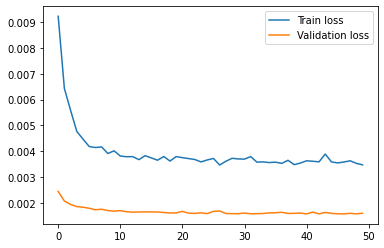

In [40]:
plt.plot(model_fit.history['loss'], label='Train loss')
plt.plot(model_fit.history['val_loss'], label='Validation loss')
plt.legend()
print('Train MSE minimum:', min(model_fit.history['loss']))
print('Validation MSE minimum:', min(model_fit.history['val_loss']))

In [41]:
#Invert scaling
data_daily[['House overall']] = scaler_target.inverse_transform(data_daily[['House overall']])
Y_pred = scaler_target.inverse_transform(Y_pred)
Train_pred = scaler_target.inverse_transform(Train_pred)

MSE: 0.03783
RMSE: 0.19450
MAE: 0.144
MAPE: 0.337
R^2 score: 0.873


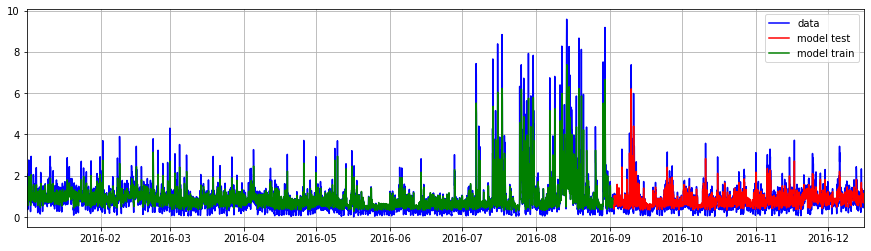

In [42]:
Y_pred_series = pd.Series(Y_pred.flatten().tolist(), index=data_daily['House overall'][size:-n_past].index)
Train_pred_series = pd.Series(Train_pred.flatten().tolist(), index=data_daily['House overall'][n_past:size].index)
plt.figure(figsize=(15,4))
plt.plot(data_daily['House overall'][:-n_past], c='blue', label='data')
plt.plot(Y_pred_series, c='red', label='model test')
plt.plot(Train_pred_series, c='green', label='model train')
plt.legend()
plt.grid(), plt.margins(x=0);
Y_test = data_daily['House overall'][size:-n_past]

# calcolo errore
print('MSE: %.5f' % (mean_squared_error(Y_pred, Y_test)))
print('RMSE: %.5f' % np.sqrt(mean_squared_error(Y_pred, Y_test)))
MAE = mean_absolute_error(Y_test, Y_pred)
MAPE = np.mean(np.abs(Y_pred[:,0] - Y_test.values)/np.abs(Y_test.values))
#MASE = np.mean(np.abs(Y_test - Y_pred))/(np.abs(np.diff(X_train)).sum()/(len(X_train)-1))
print('MAE: %.3f' % MAE)
print('MAPE: %.3f' %MAPE)
#print('MASE: %.3f' %MASE)
print('R^2 score: %.3f' % r2_score(Y_test, Y_pred))

In [43]:
data_daily['House overall']

time
2016-01-01 05:00:00    1.044130
2016-01-01 06:00:00    0.918167
2016-01-01 07:00:00    0.714736
2016-01-01 08:00:00    0.960013
2016-01-01 09:00:00    0.639836
2016-01-01 10:00:00    1.219416
2016-01-01 11:00:00    0.798747
2016-01-01 12:00:00    0.537055
2016-01-01 13:00:00    0.358377
2016-01-01 14:00:00    0.756720
2016-01-01 15:00:00    1.470581
2016-01-01 16:00:00    1.321636
2016-01-01 17:00:00    1.916689
2016-01-01 18:00:00    2.095390
2016-01-01 19:00:00    1.304323
2016-01-01 20:00:00    1.271278
2016-01-01 21:00:00    1.484986
2016-01-01 22:00:00    1.928763
2016-01-01 23:00:00    2.030315
2016-01-02 00:00:00    2.758439
2016-01-02 01:00:00    1.431200
2016-01-02 02:00:00    0.945283
2016-01-02 03:00:00    0.774271
2016-01-02 04:00:00    1.489006
2016-01-02 05:00:00    1.349401
2016-01-02 06:00:00    0.769654
2016-01-02 07:00:00    0.784055
2016-01-02 08:00:00    0.994467
2016-01-02 09:00:00    0.778566
2016-01-02 10:00:00    0.814647
2016-01-02 11:00:00    0.922265
201

In [44]:
final_data = pd.DataFrame(data_daily['House overall'])
final_data = final_data.rename(columns={'House overall':'House overall Actual (kWh)'})

prediction_df = pd.DataFrame(Train_pred_series, columns=['House overall Predicted (kWh)'])

final_data = final_data.merge(prediction_df, on='time', how='outer')
final_data = final_data.dropna()

final_data.to_csv(f'output_data/Final_data{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.csv')
final_data

House overall Actual (kWh)  House overall Predicted (kWh)
time                                                                          
2016-01-01 06:00:00                    0.918167                       1.022268
2016-01-01 07:00:00                    0.714736                       0.969652
2016-01-01 08:00:00                    0.960013                       0.865351
2016-01-01 09:00:00                    0.639836                       0.958838
2016-01-01 10:00:00                    1.219416                       0.804588
2016-01-01 11:00:00                    0.798747                       1.154854
2016-01-01 12:00:00                    0.537055                       0.904499
2016-01-01 13:00:00                    0.358377                       0.724846
2016-01-01 14:00:00                    0.756720                       0.550997
2016-01-01 15:00:00                    1.470581                       0.815784
2016-01-01 16:00:00                    1.321636                       1.153740
2016-01-01 17:00:00                    1.916689                       1.114986
2016-01-01 18:00:00                    2.095390                       1.386871
2016-01-01 19:00:00                    1.304323                       1.504279
2016-01-01 20:00:00                    1.271278                       1.085007
2016-01-01 21:00:00                    1.484986                       1.076409
2016-01-01 22:00:00                    1.928763                       1.282488
2016-01-01 23:00:00                    2.030315                       1.568720
2016-01-02 00:00:00                    2.758439                       1.497311
2016-01-02 01:00:00                    1.431200                       1.955255
2016-01-02 02:00:00                    0.945283                       1.161550
2016-01-02 03:00:00                    0.774271                       0.895435
2016-01-02 04:00:00                    1.489006                       0.810199
2016-01-02 05:00:00                    1.349401                       1.205781
2016-01-02 06:00:00                    0.769654                       1.157984
2016-01-02 07:00:00                    0.784055                       0.894924
2016-01-02 08:00:00                    0.994467                       0.891852
2016-01-02 09:00:00                    0.778566                       0.966398
2016-01-02 10:00:00                    0.814647                       0.904580
2016-01-02 11:00:00                    0.922265                       0.912335
2016-01-02 12:00:00                    1.611039                       0.946585
2016-01-02 13:00:00                    1.394281                       1.391989
2016-01-02 14:00:00                    0.724210                       1.200062
2016-01-02 15:00:00                    0.731881                       0.864779
2016-01-02 16:00:00                    0.286910                       0.858847
2016-01-02 17:00:00                    0.260415                       0.592627
2016-01-02 18:00:00                    0.630465                       0.559951
2016-01-02 19:00:00                    1.624804                       0.779456
2016-01-02 20:00:00                    1.767218                       1.376107
2016-01-02 21:00:00                    2.157249                       1.533673
2016-01-02 22:00:00                    2.924248                       1.736624
2016-01-02 23:00:00                    2.934710                       2.049800
2016-01-03 00:00:00                    1.738002                       1.958835
2016-01-03 01:00:00                    2.073860                       1.233467
2016-01-03 02:00:00                    1.612097                       1.486830
2016-01-03 03:00:00                    0.798349                       1.253347
2016-01-03 04:00:00                    0.997916                       0.808393
2016-01-03 05:00:00                    0.713656                       0.959221
2016-01-03 06:00:00                    0.869194                       0

# Energy Price data in Alberta

In [54]:
energy_price_data = pd.read_csv('input_data/Hourly_Pool_Price_Alberta.csv')
energy_price_data = energy_price_data.rename(columns={'Datetime':'time'})


energy_price_data['time'] = energy_price_data["time"].apply(lambda x: datetime.strptime(x,"%Y/%m/%d %H:%M"))
energy_price_data['time'] = pd.DatetimeIndex(energy_price_data['time'])
energy_price_data = energy_price_data.set_index('time')


energy_price_data["Price ($/kWh)"] = energy_price_data["Price ($/MWh)"].apply(lambda x: x/1000.0)
energy_price_data = energy_price_data.drop(columns = "Price ($/MWh)")
energy_price_data

Price ($/kWh)
time                              
2016-01-01 00:00:00        0.01422
2016-01-01 01:00:00        0.01402
2016-01-01 02:00:00        0.01390
2016-01-01 03:00:00        0.01403
2016-01-01 04:00:00        0.01403
2016-01-01 05:00:00        0.01403
2016-01-01 06:00:00        0.01403
2016-01-01 07:00:00        0.01367
2016-01-01 08:00:00        0.01323
2016-01-01 09:00:00        0.01253
2016-01-01 10:00:00        0.01107
2016-01-01 11:00:00        0.01107
2016-01-01 12:00:00        0.01107
2016-01-01 13:00:00        0.01106
2016-01-01 14:00:00        0.01124
2016-01-01 15:00:00        0.01199
2016-01-01 16:00:00        0.01301
2016-01-01 17:00:00        0.01503
2016-01-01 18:00:00        0.01688
2016-01-01 19:00:00        0.01913
2016-01-01 20:00:00        0.01936
2016-01-01 21:00:00        0.01864
2016-01-01 22:00:00        0.01903
2016-01-01 23:00:00        0.01948
2016-01-02 00:00:00        0.02123
2016-01-02 01:00:00        0.02090
2016-01-02 02:00:00        0.02066
2016-01-02 03:00:00        0.02044
2016-01-02 04:00:00        0.01966
2016-01-02 05:00:00        0.01874
2016-01-02 06:00:00        0.01981
2016-01-02 07:00:00        0.01943
2016-01-02 08:00:00        0.01949
2016-01-02 09:00:00        0.01847
2016-01-02 10:00:00        0.01932
2016-01-02 11:00:00        0.01960
2016-01-02 12:00:00        0.01963
2016-01-02 13:00:00        0.01950
2016-01-02 14:00:00        0.01941
2016-01-02 15:00:00        0.02108
2016-01-02 16:00:00        0.02052
2016-01-02 17:00:00        0.02138
2016-01-02 18:00:00        0.02168
2016-01-02 19:00:00        0.02150
2016-01-02 20:00:00        0.02165
2016-01-02 21:00:00        0.02052
2016-01-02 22:00:00        0.02064
2016-01-02 23:00:00        0.02329
2016-01-03 00:00:00        0.02617
2016-01-03 01:00:00        0.02323
2016-01-03 02:00:00        0.02251
2016-01-03 03:00:00        0.02251
2016-01-03 04:00:00        0.02143
2016-01-03 05:00:00        0.01954
2016-01-03 06:00:00        0.01793
2016-01-03 07:00:00        0.01535
2016-01-03 08:00:00        0.01615
2016-01-03 09:00:00        0.01436
2016-01-03 10:00:00        0.01298
2016-01-03 11:00:00        0.01176
2016-01-03 12:00:00        0.01234
2016-01-03 13:00:00        0.01294
2016-01-03 14:00:00        0.01255
2016-01-03 15:00:00        0.01296
2016-01-03 16:00:00        0.01368
2016-01-03 17:00:00        0.01442
2016-01-03 18:00:00        0.01543
2016-01-03 19:00:00        0.01480
2016-01-03 20:00:00        0.01476
2016-01-03 21:00:00        0.01475
2016-01-03 22:00:00        0.01501
2016-01-03 23:00:00        0.01632
2016-01-04 00:00:00        0.02353
2016-01-04 01:00:00        0.02139
2016-01-04 02:00:00        0.01913
2016-01-04 03:00:00        0.01529
2016-01-04 04:00:00        0.01480
2016-01-04 05:00:00        0.01461
2016-01-04 06:00:00        0.01466
2016-01-04 07:00:00        0.01441
2016-01-04 08:00:00        0.01476
2016-01-04 09:00:00        0.01486
2016-01-04 10:00:00        0.01919
2016-01-04 11:00:00        0.01943
2016-01-04 12:00:00        0.01863
2016-01-04 13:00:00        0.01870
2016-01-04 14:00:00        0.01922
2016-01-04 15:00:00        0.01969
2016-01-04 16:00:00        0.01889
2016-01-04 17:00:00        0.02030
2016-01-04 18:00:00        0.02177
2016-01-04 19:00:00        0.02127
2016-01-04 20:00:00        0.02098
2016-01-04 21:00:00        0.02113
2016-01-04 22:00:00        0.02092
2016-01-04 23:00:00        0.02553
2016-01-05 00:00:00        0.03562
2016-01-05 01:00:00        0.03400
2016-01-05 02:00:00        0.02251
2016-01-05 03:00:00        0.02137
2016-01-05 04:00:00        0.02041
2016-01-05 05:00:00        0.01948
2016-01-05 06:00:00        0.01931
2016-01-05 07:00:00        0.01898
2016-01-05 08:00:00        0.01859
2016-01-05 09:00:00        0.01861
2016-01-05 10:00:00        0.01550
2016-01-05 11:00:00        0.01558
2016-01-05 12:00:00        0.01675
2016-01-05 13:00:00        0.02045
2016-01-05 14:00:00        0.02676
2016-01-05 15:00:00        0.02524
2016-01-05 16:00:00        0.02

In [55]:
energy_price_data_consumer = final_data.merge(energy_price_data, on='time', how='inner')
energy_price_data_consumer.reset_index()
energy_price_data_consumer["Energy bill payed by the customer ($)"] = energy_price_data_consumer.apply(lambda x: x["House overall Predicted (kWh)"] * x["Price ($/kWh)"], axis=1)
energy_price_data_consumer = energy_price_data_consumer.reset_index()
energy_price_data_consumer["date"] = energy_price_data_consumer["time"].apply(lambda x: x.date())
energy_price_data_consumer["timestamp"] = energy_price_data_consumer["time"].apply(lambda x: x.time())
energy_price_data_consumer.to_csv(f'output_data/Usable_data_for_analysis{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.csv')
energy_price_data_consumer

time  House overall Actual (kWh)  \
0    2016-01-01 06:00:00                    0.918167   
1    2016-01-01 07:00:00                    0.714736   
2    2016-01-01 08:00:00                    0.960013   
3    2016-01-01 09:00:00                    0.639836   
4    2016-01-01 10:00:00                    1.219416   
5    2016-01-01 11:00:00                    0.798747   
6    2016-01-01 12:00:00                    0.537055   
7    2016-01-01 13:00:00                    0.358377   
8    2016-01-01 14:00:00                    0.756720   
9    2016-01-01 15:00:00                    1.470581   
10   2016-01-01 16:00:00                    1.321636   
11   2016-01-01 17:00:00                    1.916689   
12   2016-01-01 18:00:00                    2.095390   
13   2016-01-01 19:00:00                    1.304323   
14   2016-01-01 20:00:00                    1.271278   
15   2016-01-01 21:00:00                    1.484986   
16   2016-01-01 22:00:00                    1.928763   
17   2016-01-01 23:00:00                    2.030315   
18   2016-01-02 00:00:00                    2.758439   
19   2016-01-02 01:00:00                    1.431200   
20   2016-01-02 02:00:00                    0.945283   
21   2016-01-02 03:00:00                    0.774271   
22   2016-01-02 04:00:00                    1.489006   
23   2016-01-02 05:00:00                    1.349401   
24   2016-01-02 06:00:00                    0.769654   
25   2016-01-02 07:00:00                    0.784055   
26   2016-01-02 08:00:00                    0.994467   
27   2016-01-02 09:00:00                    0.778566   
28   2016-01-02 10:00:00                    0.814647   
29   2016-01-02 11:00:00                    0.922265   
30   2016-01-02 12:00:00                    1.611039   
31   2016-01-02 13:00:00                    1.394281   
32   2016-01-02 14:00:00                    0.724210   
33   2016-01-02 15:00:00                    0.731881   
34   2016-01-02 16:00:00                    0.286910   
35   2016-01-02 17:00:00                    0.260415   
36   2016-01-02 18:00:00                    0.630465   
37   2016-01-02 19:00:00                    1.624804   
38   2016-01-02 20:00:00                    1.767218   
39   2016-01-02 21:00:00                    2.157249   
40   2016-01-02 22:00:00                    2.924248   
41   2016-01-02 23:00:00                    2.934710   
42   2016-01-03 00:00:00                    1.738002   
43   2016-01-03 01:00:00                    2.073860   
44   2016-01-03 02:00:00                    1.612097   
45   2016-01-03 03:00:00                    0.798349   
46   2016-01-03 04:00:00                    0.997916   
47   2016-01-03 05:00:00                    0.713656   
48   2016-01-03 06:00:00                    0.869194   
49   2016-01-03 07:00:00                    0.904869   
50   2016-01-03 08:00:00                    0.790551   
51   2016-01-03 09:00:00                    0.793403   
52   2016-01-03 10:00:00                    0.817984   
53   2016-01-03 11:00:00                    0.877742   
54   2016-01-03 12:00:00                    1.245039   
55   2016-01-03 13:00:00                    0.738852   
56   2016-01-03 14:00:00                    0.686422   
57   2016-01-03 15:00:00                    0.715184   
58   2016-01-03 16:00:00                    1.233586   
59   2016-01-03 17:00:00                    1.141592   
60   2016-01-03 18:00:00                    0.783570   
61   2016-01-03 19:00:00                    0.776253   
62   2016-01-03 20:00:00                    1.371636   
63   2016-01-03 21:00:00                    1.886244   
64   2016-01-03 22:00:00                    2.052697   
65   2016-01-03 23:00:00                    1.900106   
66   2016-01-04 00:00:00                    1.627602   
67   2016-01-04 01:00:00                    1.538681   
68   2016-01-04 02:00:00                    1.096110   
69   2016-01-04 03:00:00                    0.700465   
70   2016-01-04 04:00:00                    

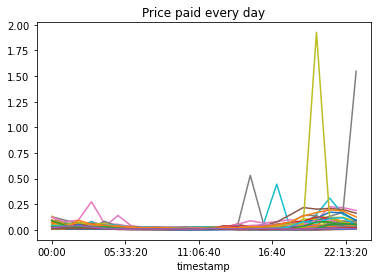

In [58]:
df = energy_price_data_consumer.copy()
df = df.set_index('timestamp')
for date, d in df.groupby('date')['Energy bill payed by the customer ($)']:
    d.plot(x='timestamp', y='Energy bill payed by the customer ($)', title = 'Price paid every day',label=date)

# Observations, Discussion & Results

### Background 

We first collected the raw energy consumption and IoT data from the house [1]and collected the raw Alberta Pool price data from Alberta Electric System Operator (AESO) website [2]. Once we collected the raw data, we investigated the components and features of the dataset through visualization and correlation mappings. The visualizations helped us to understand the smart home environment and study its feature connections which in turn helped us to train the model. Once the feature columns and target columns were selected, we researched different time series-based machine learning models. Based on our research Neural Network models were the best fit models for our energy prediction based on our features. We filtered down the models to RNN, GRU, and LTSM models for our comparison. Based on our comparison and initial evaluation of the models, LTSM gave us the most accurate results than RNN and GRU. Then we continued to tune our LTSM model and used anomaly detection to find the outliers in the dataset. Finally, were able to successfully deploy the trained LTSM model which gave us a coefficient of determination (R2) value of 87.3%. 

 
### Visualizing Data 

We will be using Pandas and NumPy for performing transformations and cleaning our dataset to best fit our deep learning model. Matplotlib and seaborn will also be used to plot our data and our results. 

The raw dataset has 31 features ranging from total power consumption, power consumption of specific appliances, and weather information for the surrounding area. After our initial assessment and to better fit our models, we choose 15 unique features that directly affect the energy consumption of the house. The reason to reduce the features is because some of the features were redundant and had a 1:1 correlation. Removing some of the complex features also helped us to train our model without overfitting. 

We have plotted a correlation matrix of total power consumption and generation in the dataset contrasted alongside the appliances' power consumption. 

We can observe in the correlation matrix the ratio of each appliance to total power consumption. The furnace is the most demanding energy sink with around 51% of total power consumption coming from its use. We can also note that all generated power from the smart home is strictly from solar. There is a 1:1 correlation between them. We can also notice that the “House overall” and “use” features also have a 1:1 correlation. We will therefore drop the “use” and “gen” columns of the dataset since they are duplicates of other columns. 

Grouping the power consumption of the appliances with different time frames such as the day of the week, months in the year, or hours in the day we can also draw some insights on which appliances get used when. Many of these visualizations make intuitive sense. For example, the furnace is not used often in the summer since it is already warm enough, so its consumption is minimal in the summer months. We can also notice that the wine cellar is used more frequently on the weekends to wind down after the work week, so its power consumption is higher on a Saturday than on a Tuesday. 

We have also plotted the correlations between the weather features of the dataset. The only notable insights found are that the temperature, apparent temperature, and dew point features are correlated.  
 
We have also analyzed the correlation between certain appliances power consumption to the surrounding weather and temperature. There are no strong correlations present here aside from the temperature and furnace usage which makes sense. 

### Anomaly detection 

We have plotted the raw power consumption relative to the time. The x-axis is the datetime value in hourly span. The y-axis the energy consumption in kW. 

We have used an Autoregressive Integrated Moving Average (ARIMA) model to find the outliers in the given set of data. We resampled the data into hourly time periods and the ARIMA model finds the anomalies in the hourly data as shown in the graph above. The green curves give us a sense of the maximum and minimum values based on the ARIMA model’s regression output. We can see in the plot that there are many outliers and anomalies (red dots) within the dataset. This is most noticeable between the months of July and October. However, it is evident that for any month there are some outliers and spikes in energy use. 

### Model Selection 

We have decided to use a recurrent neural network (RNN) architecture for our energy consumption prediction. Our dataset consists of sequential time series-based data. Each feature is for a specific moment in time. RNNs are a commonly used architecture to solve these types of problems because they have the notion of memory built into them and in time-series datasets, data at a previous time influence the outcome of data at a later time, so RNNs are a suitable architecture for solving prediction problems on time-series datasets[3]. 

There are three RNN models which we considered for our model of choice. Vanilla RNN, Long Short-Term Memory (LSTM), and Gated Recurrent Unit (GRU). 

When Vanilla RNNs are tasked to train off a dataset in the results at a current time depending on data from a faraway point in time then its results falter. This is because it has a short memory and will forget information from long ago. GRUs and LSTMs were in turn designed to help solve this issue. Both these models possess a stronger memory and can retain information for a long time which helps predict information based on long time series data. These two models do have their tradeoffs. GRUs use less system resources, particularly memory consumption and are also faster at training when compared to LSTM. However, LSTM is more accurate, especially when a dataset is very large. We have a large dataset consisting of over 8000 rows and are not in a time critical operation, so we have decided to use LSTM as our model of choice. 

### LSTM Model 

Now that we have explored and visualized some of the data, we will now train our model. 

We have used a LSTM neural network for our model to help predict the future energy trends of the smart home. What guided us to use LSTM as our model of choice was its wide applications in time series prediction on stock markets, energy prices, etc. We have used keras for our implementation. 

For our preprocessing, aside from dropping duplicate columns: we have used a min max scaler to normalize our features. The Min-Max scaler transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set. This helps us to scale and compress all the inliers in the narrow range. 

We have added 2 layers to our Keras-Sequential model. The first layer is the LTSM layer, and the second layer is a Dense layer. The LTSM layer uses a rectified linear unit activation function (Relu) with 10 as the value for the units which is th dimensionality of the output space. The Dense layer is a layer of neurons in which each neuron receives input from all the neurons of the previous layer, which helps us to deeply connect with the previous layer. We have added one Dense layer since adding more Dense layers results in decreased accuracy and model performance. 

We chose our optimizer as Adam optimizer for the LTSM model instead of the classical stochastic gradient descent. The Adam optimizer is an alternative optimization algorithm that provides more efficient neural network weights by running repeated cycles of “adaptive moment estimation.” Adam extends on stochastic gradient descent to solve non-convex problems faster while using fewer resources than many other optimization programs. This optimizer helps to train our dataset better since our features are not too complex and numerous. 

To train our model we have split our data up into training and testing datasets. 70% of the original data will be used for training while the rest will be used for testing our model’s performance. The model itself has additional dense and dropout layers to improve our performance. The dense layer is the improve the precision of the neural network as inputs pass through it. We chose a dropout ratio of 0.2 which will drop 20% randomly selected neurons and ignored during training. The dropout layer is to help prevent overfitting in our model. We first trained our model using 50 epochs. 

We can see that after around 30 epochs there is minimal improvement in our model's performance. So, increasing our epoch frequency over 30 would waste our computation time and resources for minimal improvement in our model performance. 

### Evaluation Metrics 

We can see that for the mean average error (MAE) our result is 0.144, which is quite close to zero. This signifies that the average quantitative error for any prediction is around 0.144. Given that the normalized range for power consumption is 0.5-2KW. 

Mean absolute percentage error (MAPE) is a percentile metric to indicate the errors in our predictions. Our MAPE value as a percentage is 33.7%. This means that on average we deviate around 30% for any given energy prediction. 

R-squared(R^2) Is also a percentile metric indicating how well a model explains the variance of the response data around its mean. Our model produced an R2 value of 87.3%. This score is not high enough to indicate the model would be overfitting. However, it is not low enough to also state that our model is underfitting. Therefore, our model is in the pleasant zone of right between over and underfitting. 

According to the presented evaluation metrics we can conclude that our proposed model has provided satisfactory results for our problem. 

We can now predict the total energy consumption of the smart home on a given day. Using Alberta’s public dataset containing the cost of energy for any given hour of the day we can determine how much the owners of the smart home are paying for their energy [2]. We converted the Alberta pool price data from Canadian $ per MWh to Canadian $ per kWh to match our smart home energy consumption units. Then we evaluated the predicted energy consumption and the cost in Alberta for that energy and built a table which gives us the energy bill paid by the customer hourly. 

We took this dataset and split it into daily datasets, then overlaid the plots for each day onto a single plot to interpret the trend for daily cost paid by the customer. The plot below shows how much the owners pay each hour for each day for their power. The distinct color lines indicate different days of the year while the x-axis is the hour in the day and the y-axis is the Canadian $ per kWh value. 

Observing this plot, we can determine that the nearing end of the days is when the owners pay most for their energy. This is most likely because most residents are home so more appliances are being used. We can also see that there are a few days on which the price paid is significantly higher than the average. This is likely caused by a surge in the price of electricity for those days or hours. 

# Conclusion

We have visualized some of the raw data from the dataset and drew correlations between total energy consumption and the energy consumption of specific appliances. From here we realized a few insights about the resident's power usage patterns. For example, the furnace has a high correlation with that total power consumption, so we know it is a large contributor to total usage, the microwave does not have high energy consumption no matter how much it is used so it has minimal effect on energy consumption, the wine cellar and living room’s power consumption are inverse of one another, etc. We have also analyzed the correlation between the weather patterns and energy consumption. The only meaningful insight drawn from that is that temperature has a direct correlation with furnace use which in turn increases the energy consumption on days when it is colder. 

After we visualized our data, we performed some preprocessing on our data and split the data into training and testing sets. Once that was complete, we started to train our LSTM model with the cleaned data. We added additional dense and dropout layers to our model to improve the precision of the predictions and trained initially with 50 epochs. We determined that anything more than 30 epochs has negligible improvements on our model's performance. Our performance indicators signified that our model has adequate performance at predicting the power consumption for the household with a R2 score of 0.873. 

Once we trained our model, we added another dataset containing the hourly prices of energy in Alberta to our analysis [2]. By using the new dataset, we determined how much the owners of the smart home would pay for any given period.  

After analyzing the smart home and price data we can draw some conclusions on how the owners could pragmatically save money. In general, the price of energy is cheapest between 8am and 3pm. Therefore, choosing to run certain appliances such as the dish washer or cooking in the kitchen would be optimal during those times.  

### Future Developments 

In the Future, we could train a new model to predict the cost of energy in Alberta using features from the market data and weather data. Then by combining both our models we could predict how much the smart home would pay for energy for any day of the year. Therefore, if the model predicts that the owners would have high fees for a certain day, they could try to minimize using power for that day by cooking on the days before or doing chores prior.



### References 


[1]  T. S. Anttal, "Smart Home Dataset with weather Information," Kaggle, [Online]. Available: https://www.kaggle.com/datasets/taranvee/smart-home-dataset-with-weather-information. [Accessed 1 Dec 2022]. 

[2]  "Report Start - AESO ETS," AESO, [Online]. Available: http://ets.aeso.ca/ets_web/docroot/Market/Reports/HistoricalReportsStart.html. [Accessed 1 December 2022]. 

[3]  V. Lendave, "LSTM Vs GRU in Recurrent Neural Network: A Comparative Study," 2021.  
